In [0]:
#Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

np.set_printoptions(suppress=True)

In [0]:
#use seed to reproduce the results.
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Load the cifar dataset

In [3]:
#download data
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#labels 0,1,8,9 --->  Transport
#labels 2,3,4,5,6,7 ----> Animals
#For training data combine the 10 classes to two classes,0 for transport and 1 for animals

y_train[np.where(np.isin(y_train,[0,1,8,9]))] = 0
y_train[np.where(np.isin(y_train,[2,3,4,5,6,7]))] = 1

#two classes labels
labels = ['Transport','Animal']


#For test data combine the 10 classes to two classes,0 for transport and 1 for animals
y_test[np.where(np.isin(y_test,[0,1,8,9]))] = 0
y_test[np.where(np.isin(y_test,[2,3,4,5,6,7]))] = 1

170500096/170498071 [==============================] - 2s 0us/step



## Load the library and create a writer that will output information for tensorboard

In [4]:
#Install the library for using tensorboard in the colab environment
!pip install tensorboardcolab

In [5]:
#Load the library and create a writer that will output information for tensorboard
import tensorboardcolab

Using TensorFlow backend.


In [6]:
tbc = tensorboardcolab.TensorBoardColab()

writer = tbc.get_writer()

Wait for 8 seconds...


W0720 22:57:31.192485 139637672183680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



TensorBoard link:
https://c354d781.ngrok.io


## Normalize the inputs and reshape the labels

In [0]:
#reshape training labels to one-hot coding
y_input = tf.keras.utils.to_categorical(y_train[:40000])

#normalise the training data
x_input = (x_train[:40000]  / 255.0)

#subset validatuon data and reshape validation labels to one-hot coding
y_valid = tf.keras.utils.to_categorical(y_train[40000:])
x_valid = (x_train[40000:] / 255.0)

#reshape test data
x_test_input = x_test / 255.0



In [0]:
#function to divide the data into batches for training
data_index = 0
def generate_batch(batch_size):
    global data_index
    batch = np.ndarray(shape=(batch_size, 32, 32, 3), dtype=np.float32)  #the same shapes as train data
    labels = np.ndarray(shape=(batch_size,2), dtype=np.float32)
    for i in range(batch_size):
        batch[i] = x_input[data_index]
        labels[i] = y_input[data_index]
        data_index = (data_index + 1) % len(x_input)
    return batch, labels

## Create the placeholders

In [0]:
#Create placeholders for data input for the model.
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

## Now we'll build the convolutional layer

In [10]:
# input Layer
conv_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3),activation=tf.nn.relu)(x)

#Flatten layer

flat_layer = tf.keras.layers.Flatten()(conv_layer)

#Fully connected layer
dense = tf.keras.layers.Dense(units=512, activation=tf.nn.tanh)(flat_layer)

# output layer using softmax activation function
y = tf.keras.layers.Dense(units=2,activation=tf.nn.softmax)(dense)

W0720 22:57:32.156351 139637672183680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Create the loss

In [0]:
#crossentropy loss function tensor
cost = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

## Set up the training parameters

In [0]:
#Initial Learnin rate
lr = 0.0001
#using Adam optimizer to optimize the loss function
gd_train =tf.train.AdamOptimizer(lr).minimize(cost)


In [0]:
# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# to calculate the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [0]:
#write out the graph to tensorboard
sess = tf.Session()
writer.add_graph(sess.graph)
sess.close()

In [0]:
#we'll look at training/validation accuracy and training/validation loss as it changes during training
#TensorBoard summary for the validation accuracy
val_acc = tf.summary.scalar(name='val_acc', tensor=accuracy)

#TensorBoard summary for the train accuracy
train_acc = tf.summary.scalar(name='train_acc', tensor=accuracy)

#TensorBoard summary for the validation loss
loss_val = tf.summary.scalar(name='loss_val', tensor=cost)

#TensorBoard summary for the train loss
loss_train = tf.summary.scalar(name='loss_train', tensor=cost)


## Create a session and run the training

In [16]:
#epochs=1000
#batch_size=512

#Number of epochs and batch size
epochs=250
batch_size=128

#Global variables initializer
init = tf.global_variables_initializer()

#Starting the Tensorflow session
sess = tf.Session()

#Initializing the Variables
sess.run(init)

#Iterating through all the epochs
for i in range(epochs):
  
  # generate data batches
  batch_x, batch_y = generate_batch(batch_size)
  
  #Feeding data into optimizer and calculate the training loss function and training accuracy
  _,train_loss, train_accuracy = sess.run([gd_train,loss_train,train_acc], feed_dict={x:batch_x, y_:batch_y})
  
      
  #Feeding data into optimizer and calculate the validation loss function and validation accuracy
  val_accuracy,val_loss= sess.run([val_acc,loss_val], feed_dict = { x: x_valid, y_: y_valid})
  
  #
  writer.add_summary(train_accuracy,i)
  writer.add_summary(val_accuracy,i)
  writer.add_summary(val_loss,i)
  writer.add_summary(train_loss,i)

  if i%10 == 0:
    print('Training Step:' + str(i) + '  valid_Loss = ' + str(sess.run(cost, {x: x_valid, y_: y_valid})) +  '  train_Loss = ' + str(sess.run(cost, {x: batch_x, y_: batch_y})))
    

Training Step:0  valid_Loss = 0.984347  train_Loss = 1.0139873
Training Step:10  valid_Loss = 0.47301415  train_Loss = 0.42702603
Training Step:20  valid_Loss = 0.4735528  train_Loss = 0.48554087
Training Step:30  valid_Loss = 0.46841225  train_Loss = 0.6104026
Training Step:40  valid_Loss = 0.4234593  train_Loss = 0.519433
Training Step:50  valid_Loss = 0.4152832  train_Loss = 0.349752
Training Step:60  valid_Loss = 0.41216782  train_Loss = 0.34594965
Training Step:70  valid_Loss = 0.40626085  train_Loss = 0.5383918
Training Step:80  valid_Loss = 0.39594883  train_Loss = 0.3910206
Training Step:90  valid_Loss = 0.38878864  train_Loss = 0.337808
Training Step:100  valid_Loss = 0.38464078  train_Loss = 0.3266209
Training Step:110  valid_Loss = 0.38107654  train_Loss = 0.37908694
Training Step:120  valid_Loss = 0.37352487  train_Loss = 0.33371636
Training Step:130  valid_Loss = 0.36979017  train_Loss = 0.37943435
Training Step:140  valid_Loss = 0.361901  train_Loss = 0.2878958
Training S

In [17]:
#calculate test data accuracy and print it
y_prob = sess.run(y, feed_dict={x: x_test_input})
y_pred = np.argmax(y_prob,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))

test accuracy:  0.8715


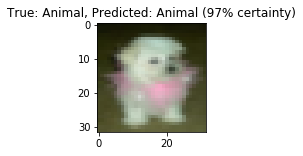

In [18]:
#Testing a single image
i=3000

label = y_test[i]
image = x_test[i]
plt.figure(figsize=(2,2))
plt.grid(False)
plt.title('True: %s, Predicted: %s (%d%% certainty)' % (labels[int(label)],labels[y_prob[i].argmax()],100*y_prob[i,y_prob[i].argmax()]))
plt.imshow(image)
plt.show()

In [0]:
sess.close()